In [1]:
from dichasus_cf0x import test_set, spec
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm.auto import tqdm

2024-02-10 16:44:13.058178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 16:44:13.787879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-10 16:44:14.869018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-10 16:44:14.900026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
test_set_positions = np.load("results/test_set_positions.npy")
test_set_csi_gan_randomnoise = np.load("results/test_set_csi_gan_randomnoise.npy")
test_set_csi_gan_fixednoise = np.load("results/test_set_csi_gan_fixednoise.npy")
test_set_csi_interpolated = np.load("results/test_set_csi_interpolated.npy")
test_set_csi_interpolated_valid = np.load("results/test_set_csi_interpolated_valid.npy")

In [3]:
# Use "training set" CSI to predict CSI at test set positions
test_set_csi_cplx = []

with tqdm(total = len(test_set_positions)) as pbar:
    for csi, pos, time, ds in test_set.batch(100):
        test_set_csi_cplx.append(csi.numpy())
        pbar.update(tf.shape(csi)[0].numpy())

test_set_csi_cplx = np.concatenate(test_set_csi_cplx)

  0%|          | 0/20973 [00:00<?, ?it/s]

In [4]:
test_set_csi = np.stack([np.real(test_set_csi_cplx), np.imag(test_set_csi_cplx)], axis = -1)

In [5]:
def plot_powers(title, positions, generated_csi, valid = None):
    if valid is None:
        valid = np.arange(len(generated_csi))
    else:
        valid = np.argwhere(valid).flatten()
    
    for ant in range(tf.shape(generated_csi)[1].numpy()):
        plt.figure(figsize=(7, 7))
        plt.title(title + ": Power - Antenna " + str(ant))
        plt.hexbin(positions[valid,0], positions[valid,1], C = 10 * np.log10(np.sum(tf.gather(generated_csi, valid)[:,ant,...]**2, axis = (1, 2, 3, 4))), gridsize = 40)
        plt.xlabel("Transmitter Position x [m]")
        plt.ylabel("Transmitter Position y [m]")
        plt.xlim((-12.5, 2.5))
        plt.ylim((-15.5, -0.5))
        plt.colorbar(label = "Power [dB]")
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.title(title + ": Power Histogram - Antenna " + str(ant))
        plt.xlabel("Delay Spread")
        plt.ylabel("Occurences")
        plt.hist(10 * np.log10(np.sum(tf.gather(generated_csi, valid)[:,ant,...]**2, axis = (1, 2, 3, 4))), bins = 100, range = (0, 35))
        plt.show()

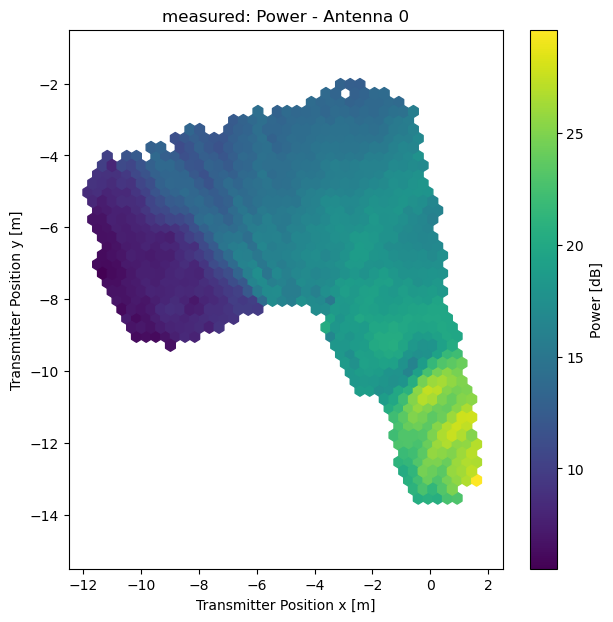

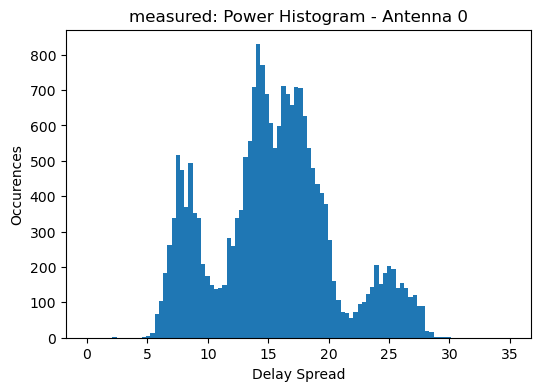

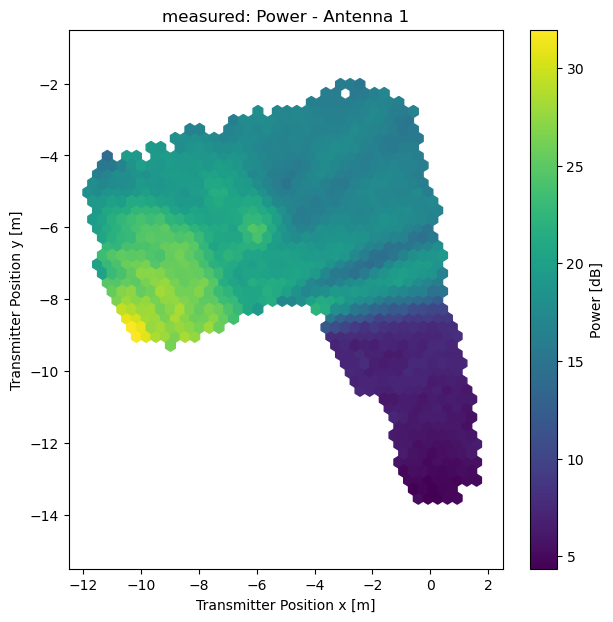

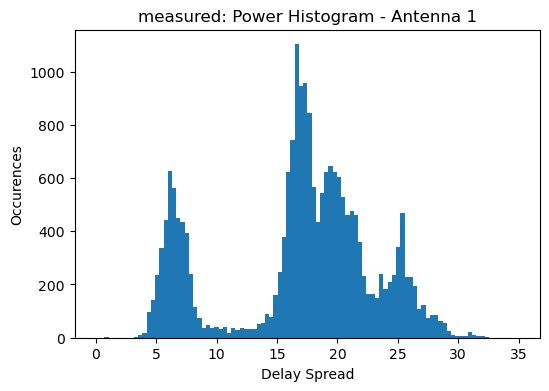

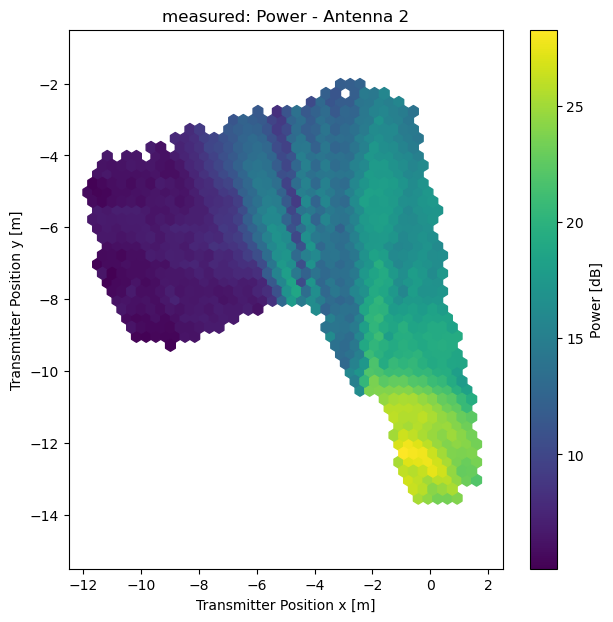

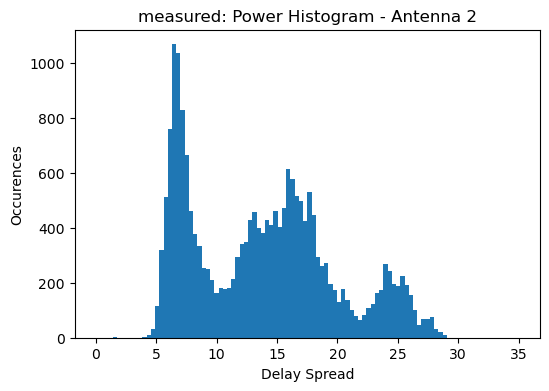

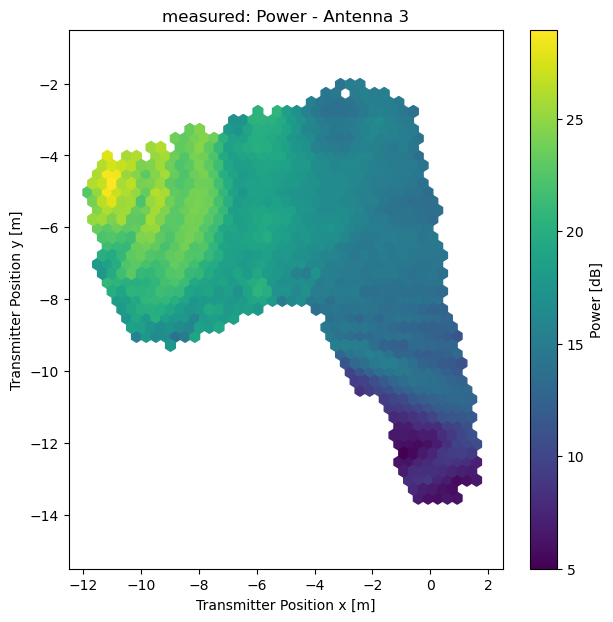

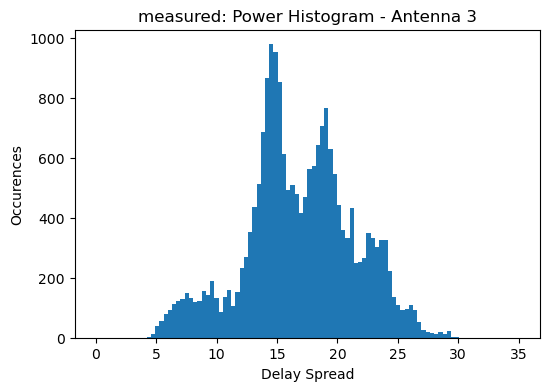

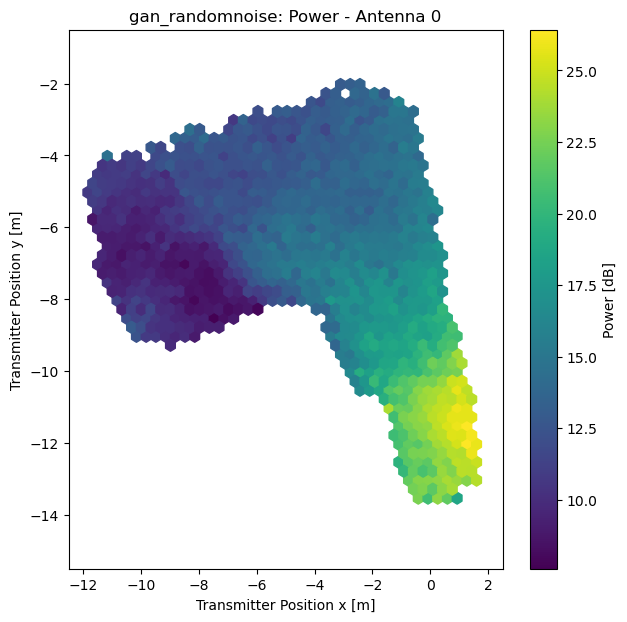

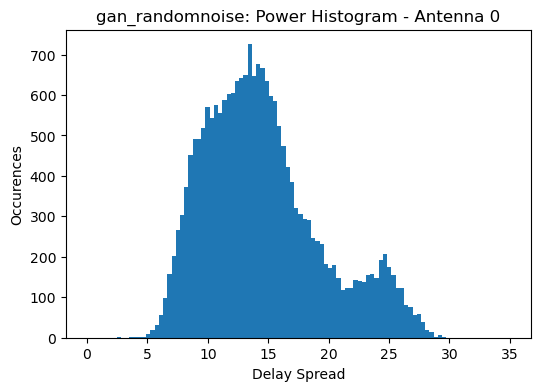

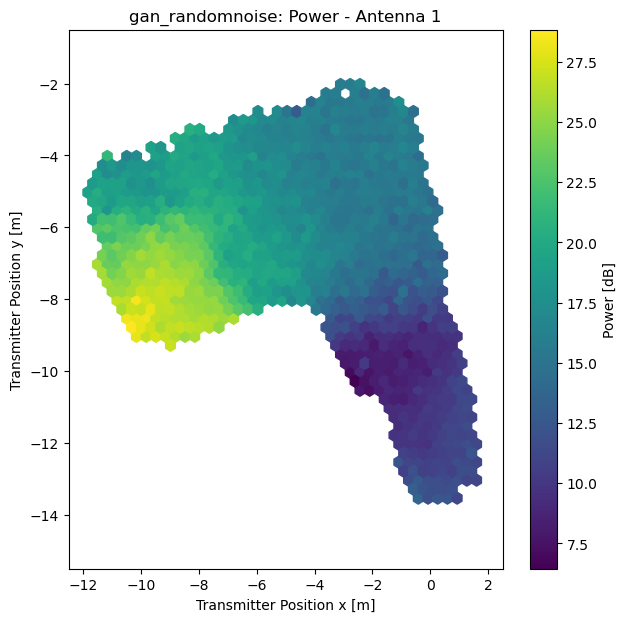

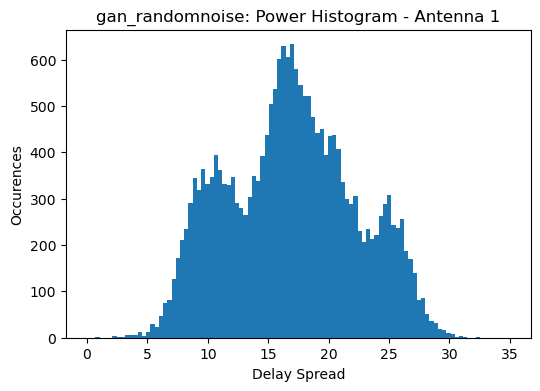

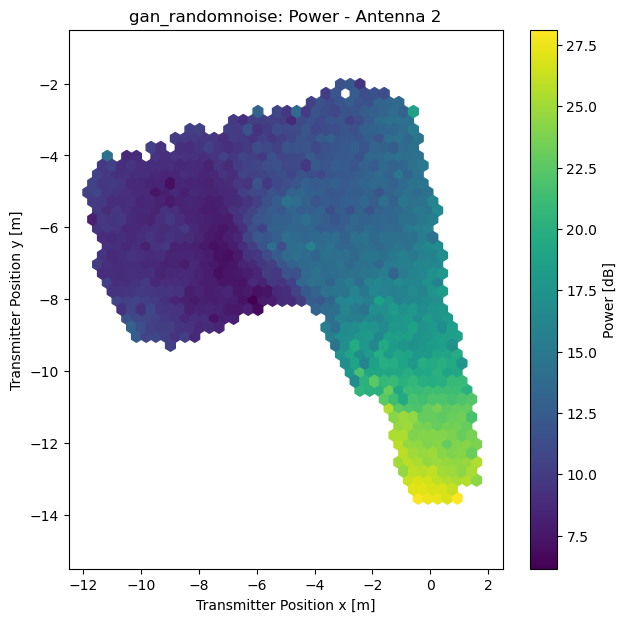

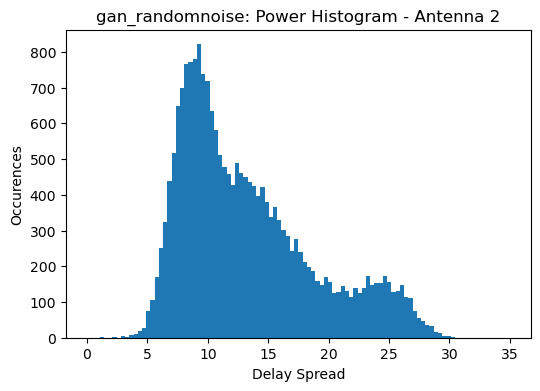

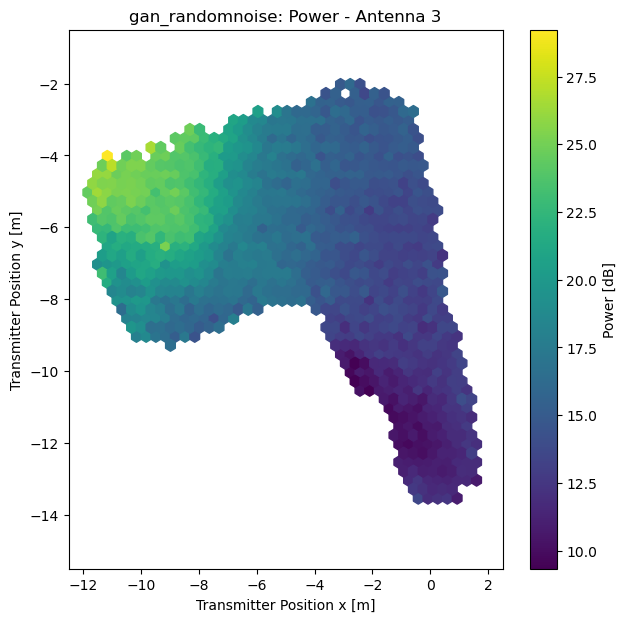

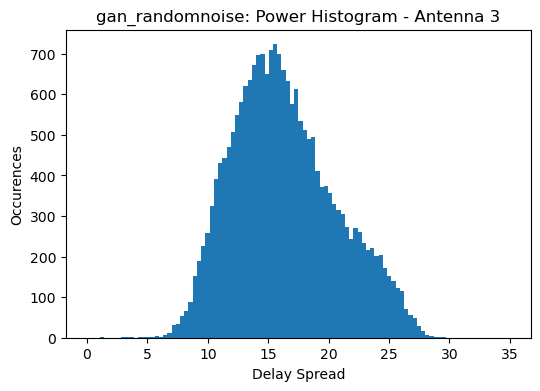

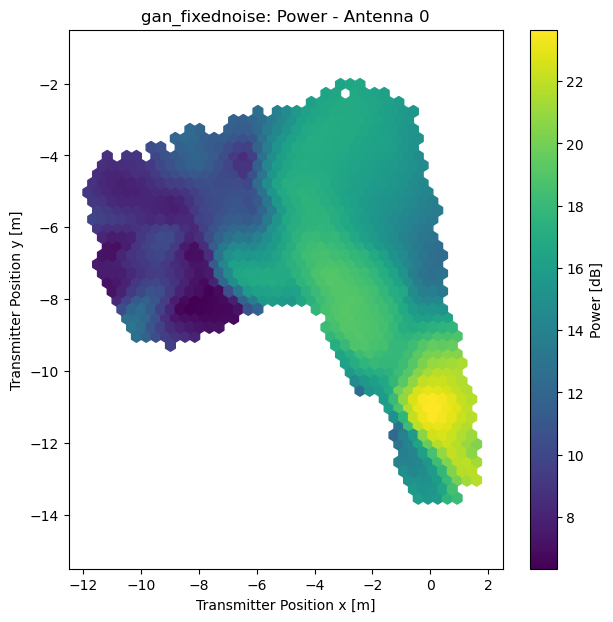

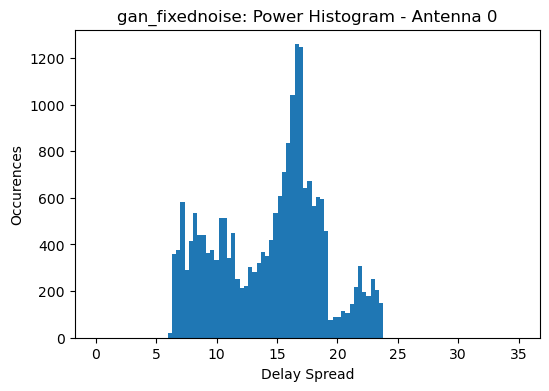

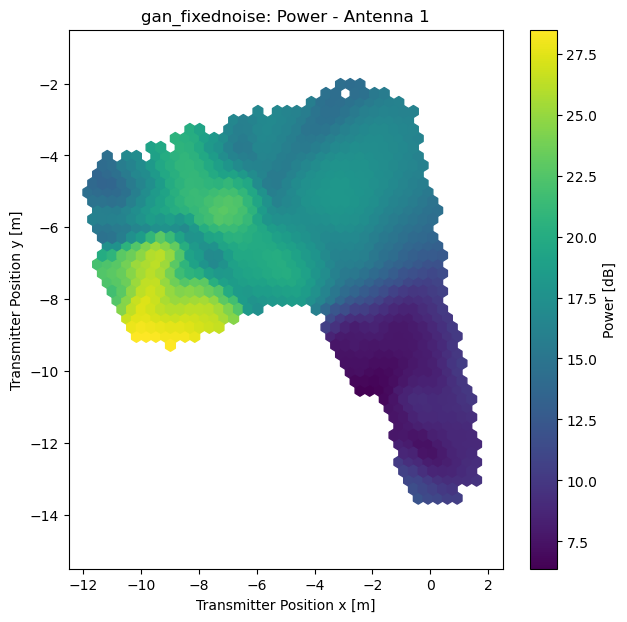

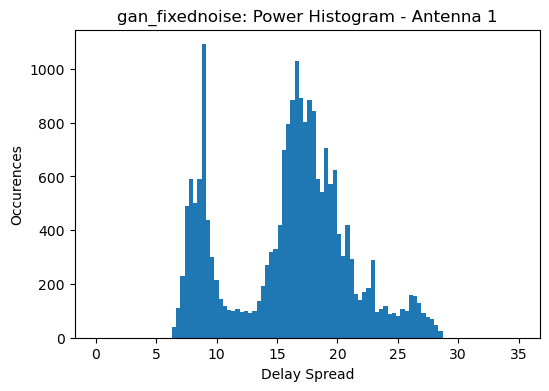

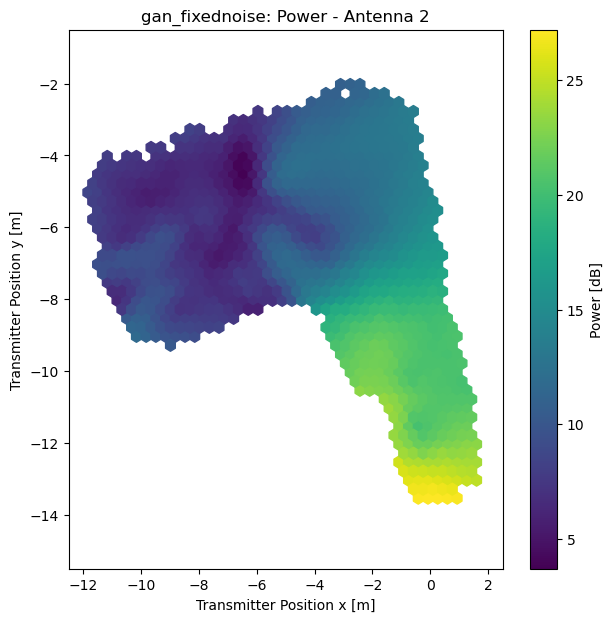

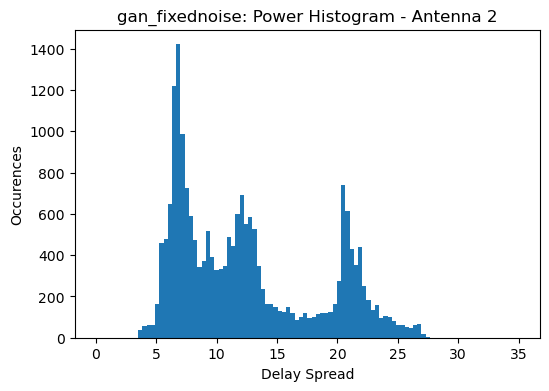

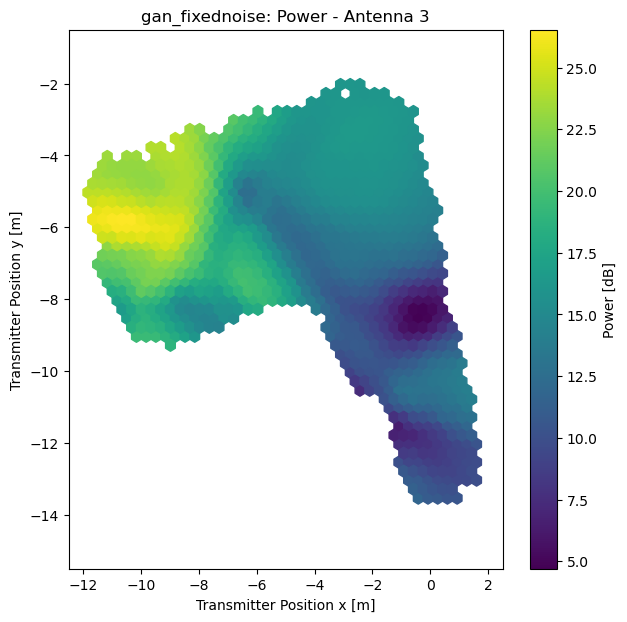

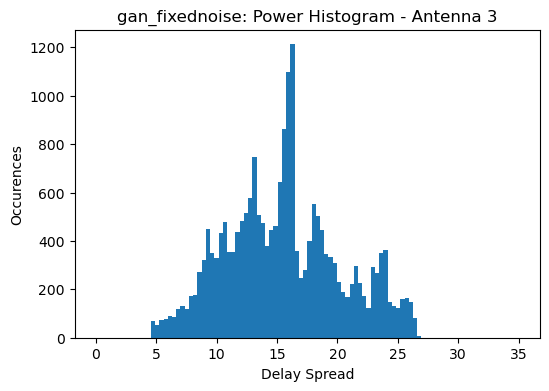

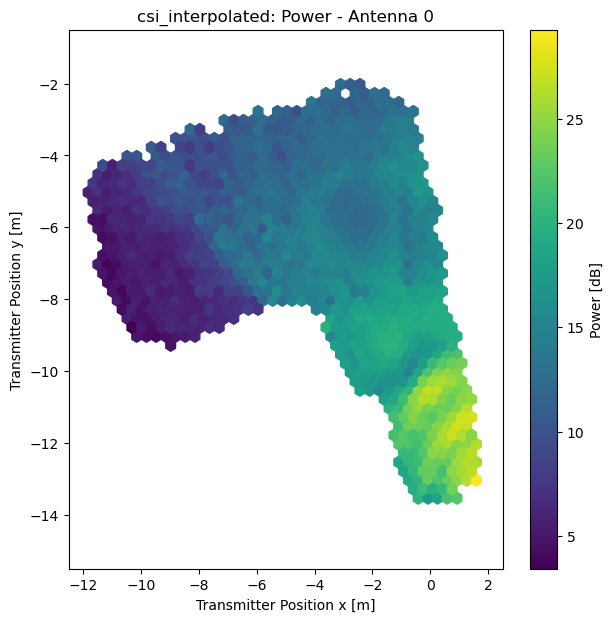

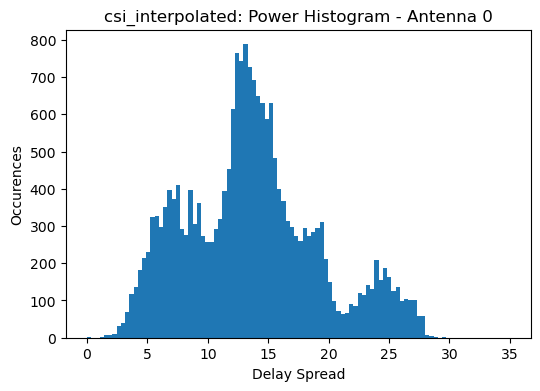

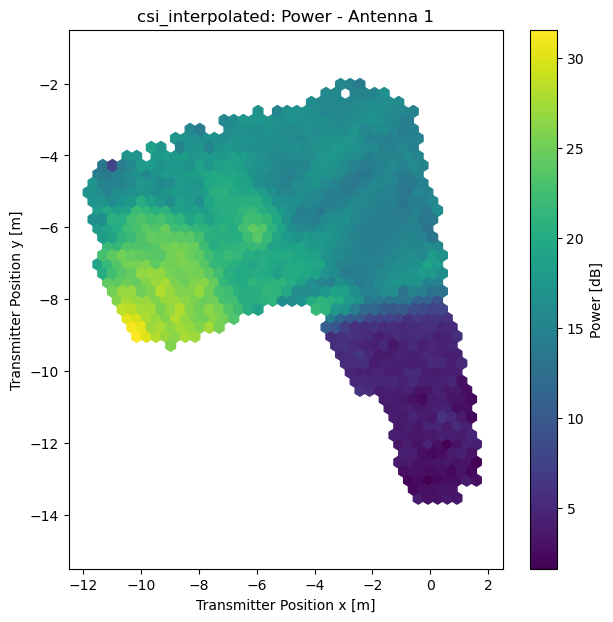

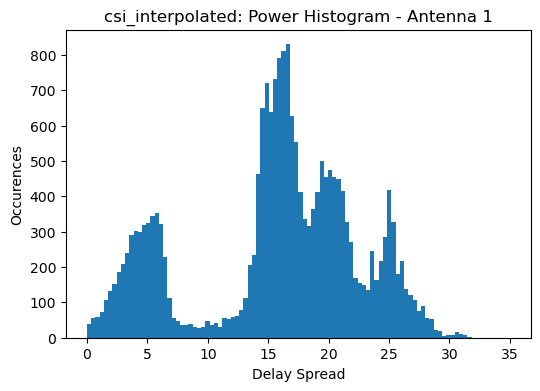

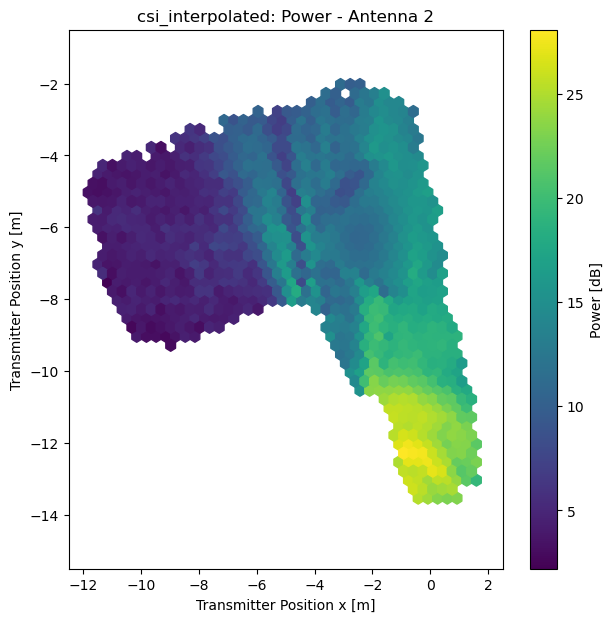

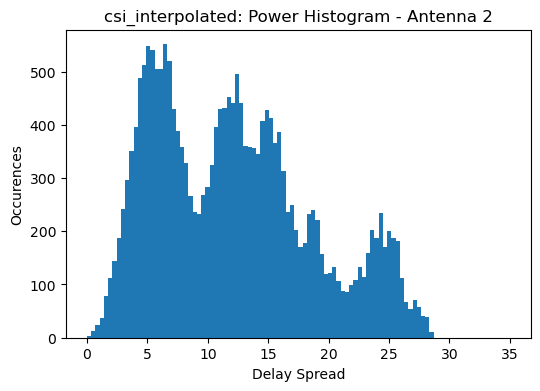

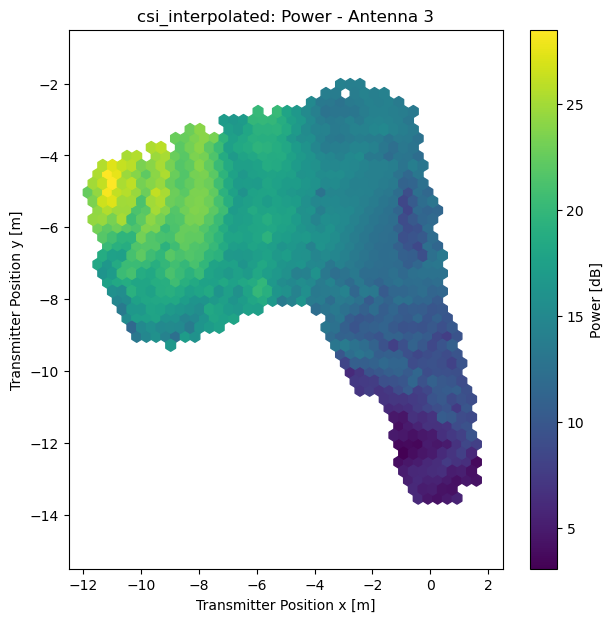

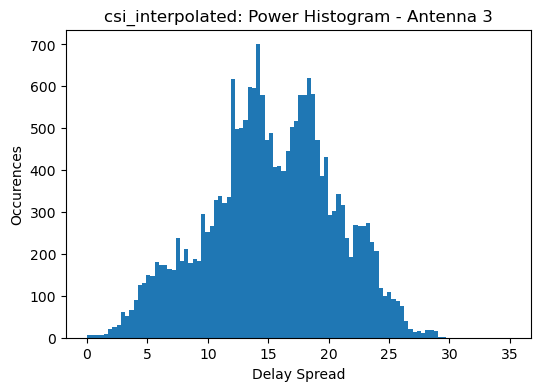

In [6]:
plot_powers("measured", test_set_positions, test_set_csi)
plot_powers("gan_randomnoise", test_set_positions, test_set_csi_gan_randomnoise)
plot_powers("gan_fixednoise", test_set_positions, test_set_csi_gan_fixednoise)
plot_powers("csi_interpolated", test_set_positions, test_set_csi_interpolated, test_set_csi_interpolated_valid)